In [1]:
import pandas as pd
import joblib
import sys
import os
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from pytorch_tabnet.tab_model import TabNetClassifier


In [ ]:
MODEL_SIZE = 'large' 
CLASSIFICATION = 'multiclass'
DATASET = 'ton'

OUTPUT_DIR = '../src/model' 

MODEL_PATH = os.path.join(OUTPUT_DIR, f'tabnet_{CLASSIFICATION}_model_{MODEL_SIZE}_{DATASET}.zip')
PREPROCESSOR_PATH = os.path.join(OUTPUT_DIR, f'preprocessor_{CLASSIFICATION}_{MODEL_SIZE}_{DATASET}.pkl')
ENCODER_PATH = os.path.join(OUTPUT_DIR,f'label_encoder_{CLASSIFICATION}_{MODEL_SIZE}.pkl')
TEST_SET_PATH = '../src/data/test_set.csv' 
TARGET_COLUMN = 'Attack' 

print(f"Model path: {MODEL_PATH}")
print(f"Preprocessor path: {PREPROCESSOR_PATH}")
print(f"Test set path: {TEST_SET_PATH}")

Model path: ../src/model/tabnet_multiclass_model_large.zip
Preprocessor path: ../src/model/preprocessor_multiclass_large.pkl
Test set path: ../src/data/test_set.csv


In [3]:
print("Model and preprocessor loading...")

try:
    loaded_preprocessor = joblib.load(PREPROCESSOR_PATH)

    loaded_model = TabNetClassifier()
    loaded_model.load_model(MODEL_PATH)

    print("Loaded")

except FileNotFoundError as e:
    print(f"ERROR: File not found. {e}")


Model and preprocessor loading...


/home/mat/tesi_triennale/neural-tabular-intrusion-detection-system/venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Loaded


In [4]:
print("Test set and label ancoder loading")
le = joblib.load(ENCODER_PATH)

test_df = pd.read_csv(TEST_SET_PATH)

X_test = test_df.drop(columns=[TARGET_COLUMN])
y_test = test_df[TARGET_COLUMN]
y_test_encoded = le.transform(y_test)

print(f": {len(test_df)} rows.")

X_test_processed = loaded_preprocessor.transform(X_test)


Test set and label ancoder loading
: 448668 rows.


/home/mat/tesi_triennale/neural-tabular-intrusion-detection-system/src/data/preprocessor.py:131: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df[col_name].fillna(unknown_code, inplace=True)
/home/mat/tesi_triennale/neural-tabular-intrusion-detection-system/src/data/preprocessor.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object 

Prediciting...

  Report (Model: multiclass large)
                precision    recall  f1-score   support

      Analysis       0.26      0.95      0.41       245
      Backdoor       0.15      0.26      0.19       692
        Benign       1.00      1.00      1.00    430217
           DoS       0.21      0.42      0.28      1016
      Exploits       0.90      0.52      0.66      7768
       Fuzzers       0.69      0.82      0.75      5132
       Generic       0.48      0.63      0.54       980
Reconnaissance       0.71      0.58      0.64      2265
     Shellcode       0.29      0.74      0.42       328
         Worms       0.53      0.72      0.61        25

      accuracy                           0.98    448668
     macro avg       0.52      0.66      0.55    448668
  weighted avg       0.99      0.98      0.98    448668



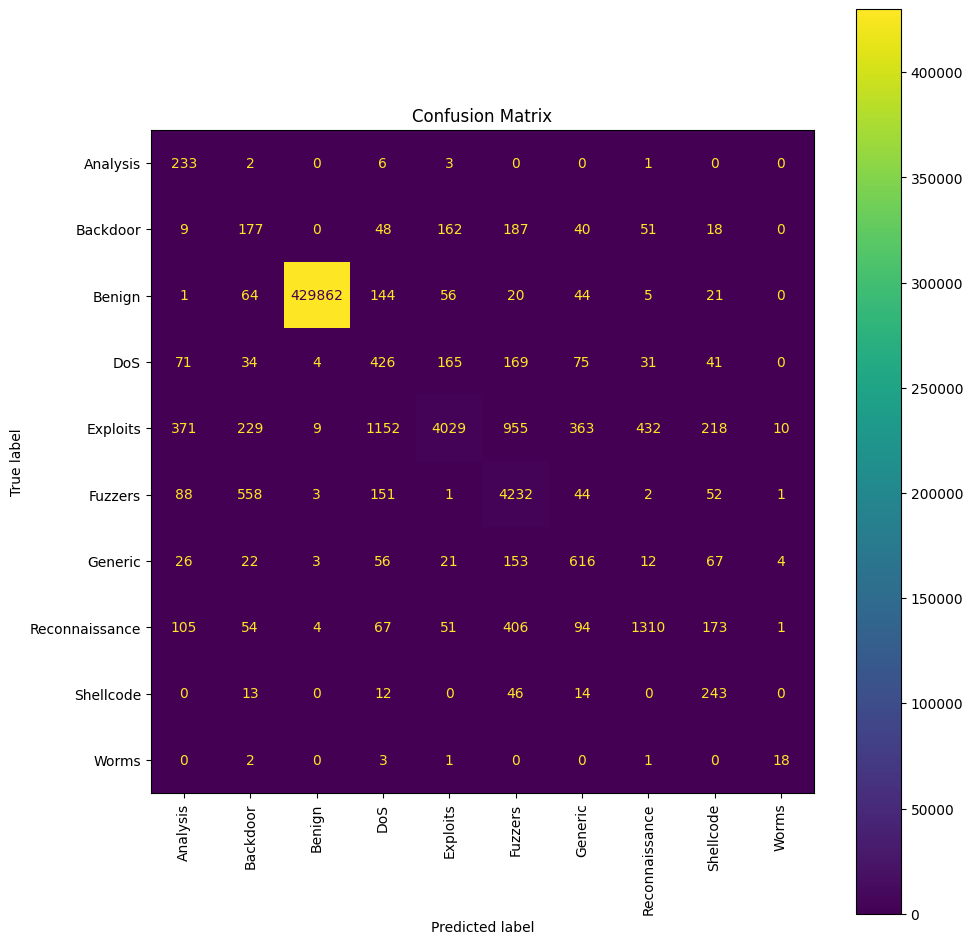

In [5]:
print("Prediciting...")
y_pred = loaded_model.predict(X_test_processed.values)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test_encoded)

report = classification_report(y_test_labels, y_pred_labels)

print("\n==============================================")
print(f"  Report (Model: {CLASSIFICATION} {MODEL_SIZE})")
print("==============================================")
print(report)

labels = le.classes_  # le etichette originali ordinate dallo label encoder
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

# 2. Visualizzazione a video
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))  # dimensione a piacere
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()